<스마트 도서관 챗봇 만들기(custom_data1)>

# 0. 데이터 확인/저장

### 1) 의도분류_추천_데이터

In [ ]:
%cd /content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_최종프로젝트/tree_chatbot

import pandas as pd

# 직접 만든 연애 상담 데이터
data = pd.read_csv('./data/csv/의도분류_추천_베스트셀러_여부(종합).csv',encoding='utf-8')
data

/content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_최종프로젝트/tree_chatbot


,input,label,label2
0,베스트 셀러 추천좀 해줘,bestseller,bestseller
1,베스트 셀러 좀 추천 해줘,bestseller,bestseller
2,최근 가장 인기 많은 책들 추천 해줘,bestseller,bestseller
3,요즘 인기 있는 책좀 추천 해줘,bestseller,bestseller
4,많이 본 책 추천해줘,bestseller,bestseller
...,...,...,...
179,사람들한테 인기 많은 책중에 {작가명} 책만 따로 알려줘,bestseller,bestseller_writer
180,{작가명} 책 중에 대표작이 있을까?,bestseller,bestseller_writer
181,{작가명} 대표작 추천해줄래?\t,bestseller,bestseller_writer
182,{작가명} 작품 중에서 사람들이 가장 좋아한 책 추천해줘,bestseller,bestseller_writer


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   184 non-null    object
 1   label   184 non-null    object
 2   label2  184 non-null    object
dtypes: object(3)
memory usage: 4.4+ KB


## 1. 저장된 단어 사전 위치

In [ ]:
# '/content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_자연어처리프로젝트/love_chatbot_sbert_v2(custom_data)/data/chatbot_dict/chatbot_dict.bin'

# 2. 핵심 단어 길이 구하기 MAX_LEN = 13으로 하면됌

In [ ]:
!pip install konlpy
from konlpy.tag import Komoran
tokenizer = Komoran()
data = pd.read_csv('./data/csv/의도분류_추천_베스트셀러_여부(종합).csv',encoding='utf-8')
data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 42.3 MB/s eta 0:00:00


,input,label,label2
0,베스트 셀러 추천좀 해줘,bestseller,bestseller
1,베스트 셀러 좀 추천 해줘,bestseller,bestseller
2,최근 가장 인기 많은 책들 추천 해줘,bestseller,bestseller
3,요즘 인기 있는 책좀 추천 해줘,bestseller,bestseller
4,많이 본 책 추천해줘,bestseller,bestseller
...,...,...,...
179,사람들한테 인기 많은 책중에 {작가명} 책만 따로 알려줘,bestseller,bestseller_writer
180,{작가명} 책 중에 대표작이 있을까?,bestseller,bestseller_writer
181,{작가명} 대표작 추천해줄래?\t,bestseller,bestseller_writer
182,{작가명} 작품 중에서 사람들이 가장 좋아한 책 추천해줘,bestseller,bestseller_writer


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   184 non-null    object
 1   label   184 non-null    object
 2   label2  184 non-null    object
dtypes: object(3)
memory usage: 4.4+ KB


In [ ]:
# data의 모든 사용자 input문장을 형태소/품사로 분해하여 리스트에 저장

input_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(input)] for input in  data['input']]

In [ ]:
len(input_tokenized)

184

In [ ]:
input_tokenized[5]

['사람/NNG',
 '들/XSN',
 '이/JKS',
 '많이/MAG',
 '보/VV',
 'ㄴ/ETM',
 '책/NNG',
 '추천/NNG',
 '하/VV',
 '아/EC',
 '주/VX',
 '어/EC']

In [ ]:
exclusion_tags = [
    'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ',
            'JX', 'JC',
            'SF', 'SP', 'SS', 'SE', 'SO',
            'EP', 'EF', 'EC', 'ETN', 'ETM',
            'XSN', 'XSV', 'XSA'
]

f = lambda x: x in exclusion_tags

core_input_tokenized = []

# i는 문장의 갯수
for i in range(len(input_tokenized)):
        temp = []
        # data_tokenized[0]=> 한 문장
        # j는 한 문장을 구성하는 '단어/품사' 갯수
        for j in range(len(input_tokenized[i])):
            # f에 품사를 넣음
            # exclusion_tags 리스트에 포함되지 않는 품사면 append!
            # 필요없는 품사가 아니면 append
            # (조사 같은 것들은 제외!)
            if f(input_tokenized[i][j].split('/')[1]) is False:
                temp.append(input_tokenized[i][j].split('/')[0])
        core_input_tokenized.append(temp)

In [ ]:
input_tokenized[150] , core_input_tokenized[150]

(['{/SS',
  '장르/NNP',
  '명/NNB',
  '}/SS',
  '중/NNB',
  '에/JKB',
  '꼭/MAG',
  '읽/VV',
  '어야/EC',
  '하/VV',
  '는/ETM',
  '책/NNG',
  '있/VX',
  '어/EF',
  '?/SF'],
 ['장르', '명', '중', '꼭', '읽', '하', '책', '있'])

토큰 길이 평균: 8.032608695652174
토큰 길이 최대: 13
토큰 길이 표준편차: 2.164190213836001


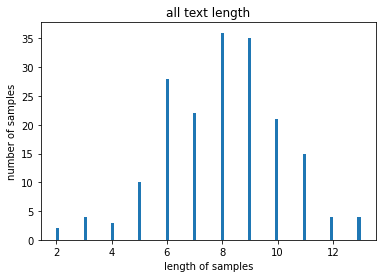

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 불용어들을 제외한 '의미있는' 단어들의 길이들을 모아놓은 num_tokens
num_tokens = [len(tokens) for tokens in core_input_tokenized]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

plt.title('all text length')
plt.hist(num_tokens, bins=100)
# bins는 가로축 구간의 개수
# (막대 그래프의 갯수)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
select_length = 13

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
        
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

# core_input_tokenized에는 전체 문장 데이터들을 token화 시킨 뒤,
# 의미있는 단어들의 품사들만 필터링한 (불용어 처리한) 단어들의 집함임!    
below_threshold_len(select_length, core_input_tokenized)

전체 샘플 중 길이가 13 이하인 샘플의 비율: 1.0


# 3. PADDING 처리

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
import pickle

%cd /content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_최종프로젝트/tree_chatbot/intent_classfiy_test

class Preprocess:
    def __init__(self, word2index_dic='./chatbot_dict/chatbot_dict.bin' ,userdic='./chatbot_dict/userdict_intent_classify_v3(library).txt'): # userdic 인자에는 사용자 정의 사전 파일 경로 입력가능
        # 단어 인덱스 사전 불러오기 추가
        if(word2index_dic != ''):
            f = open(word2index_dic, "rb")
            self.word_index = pickle.load(f)
            f.close()
            print("단어 사전 로드 완료..")
        else:
            self.word_index = None
            print("단어 사전 로드 실패..")

        # 형태소 분석기 초기화
        self.komoran = Komoran(userdic=userdic)

        # 제외할 품사
        # 참조 : https://docs.komoran.kr/firststep/postypes.html
        # 관계언 제거, 기호 제거
        # 어미 제거
        # 접미사 제거
        self.exclusion_tags = [
            'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ',
            # 주격조사, 보격조사, 관형격조사, 목적격조사, 부사격조사, 호격조사, 인용격조사
            'JX', 'JC',
            # 보조사, 접속조사
            'SF', 'SP', 'SS', 'SE', 'SO',
            # 마침표,물음표,느낌표(SF), 쉼표,가운뎃점,콜론,빗금(SP), 따옴표,괄호표,줄표(SS), 줄임표(SE), 붙임표(물결,숨김,빠짐)(SO)
            'EP', 'EF', 'EC', 'ETN', 'ETM',
            # 선어말어미, 종결어미, 연결어미, 명사형전성어미, 관형형전성어미
            'XSN', 'XSV', 'XSA'
            # 명사파생접미사, 동사파생접미사, 형용사파생접미사
        ]


    # 형태소 분석기 POS 태거
    def pos(self, sentence):
        return self.komoran.pos(sentence)

    # 불용어 제거 후 필요한 품사 정보만 가져오기
    def get_keywords(self, pos, without_tag=False):
        f = lambda x: x in self.exclusion_tags
        word_list = []
        for p in pos:
            if f(p[1]) is False:
                word_list.append(p if without_tag is False else p[0])
        return word_list

    # 키워드를 단어 인덱스 시퀀스로 변환
    def get_wordidx_sequence(self, keywords):
        if self.word_index is None:
            return []
        w2i = []
        for word in keywords:
            try:
                w2i.append(self.word_index[word])
            except KeyError:
                # 해당 단어가 사전에 없는 경우 OOV 처리
                w2i.append(self.word_index['OOV'])
        return w2i

p = Preprocess(word2index_dic='./chatbot_dict/chatbot_dict.bin' ,userdic='./chatbot_dict/userdict_intent_classify_v3(library).txt')

/content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_최종프로젝트/tree_chatbot/intent_classfiy_test
단어 사전 로드 완료..


In [ ]:
inputs = data['input'].tolist()

In [ ]:
inputs[120]

'여기서 사람들이 제일 많이 읽은 책이 뭐야?\t'

In [ ]:
!pip install tqdm
from tqdm import tqdm

sequences = []
check_keywords = True
# text는 모든 문장들의 list
for sentence in tqdm(inputs):

    # 문장을 [(단어1,품사1),(단어2,품사2)...] 로 변환
    pos = p.pos(sentence)

    # get_keywords(pos, without_tag=True) => 불용어 처리 후 품사(태그)없이 단어들만의 list
    # keywords : 불용어 처리된 [(단어1,품사1),(단어2,품사2)...], list형
    keywords = p.get_keywords(pos, without_tag=True)

    # 첫번째 keywords 와 sequence[0] 어떻게 대응되는지 체크해보고 싶음
    if check_keywords is True:
      print(keywords)
      check_keywords = False
    # 태그없이 '단어'만 있는 keywords에서 [[단어1,단어2],[단어1,단어2,단어3]...]들을 인덱싱해줌
    # 우리가 만든 단어사전에 없으면(OOV token이므로 인덱스 1로 고정)
    seq = p.get_wordidx_sequence(keywords)
    sequences.append(seq)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 184/184 [00:00<00:00, 1318.34it/s]

['베스트', '셀러', '추천', '좀', '하', '주']


In [ ]:
sequences[0]

[3437, 16683, 401, 82, 2, 35]

In [ ]:
# 최대 길이 13

MAX_SEQ_LEN = 13
padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

In [ ]:
len(padded_seqs[10]) ,len(padded_seqs[20]),len(padded_seqs[30])

(13, 13, 13)

In [ ]:
padded_seqs[10] ,padded_seqs[20],padded_seqs[30]

(array([ 3437, 16683,   401,    82,     0,     0,     0,     0,     0,
            0,     0,     0,     0], dtype=int32),
 array([1478,  305,  146,   79,   68,   23,  810,   82,  209,   35,    0,
           0,    0], dtype=int32),
 array([1478,  305, 1478,  146,   79,   68,   23,  810,   82,  401,   23,
           0,    0], dtype=int32))

# 4. SBERT 활용 embedding_data 만들기


In [ ]:
# KR-SBERT 설치
!pip install -U sentence-transformers
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import torch
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=5eda85e5307ab9bc4aa8e71f313286296dadb510ef2116be0339967dacac7c94
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


In [ ]:
data = pd.read_csv('./data/csv/의도분류_추천_베스트셀러_여부(종합).csv',encoding='utf-8')
data

,input,label,label2
0,베스트 셀러 추천좀 해줘,bestseller,bestseller
1,베스트 셀러 좀 추천 해줘,bestseller,bestseller
2,최근 가장 인기 많은 책들 추천 해줘,bestseller,bestseller
3,요즘 인기 있는 책좀 추천 해줘,bestseller,bestseller
4,많이 본 책 추천해줘,bestseller,bestseller
...,...,...,...
179,사람들한테 인기 많은 책중에 {작가명} 책만 따로 알려줘,bestseller,bestseller_writer
180,{작가명} 책 중에 대표작이 있을까?,bestseller,bestseller_writer
181,{작가명} 대표작 추천해줄래?\t,bestseller,bestseller_writer
182,{작가명} 작품 중에서 사람들이 가장 좋아한 책 추천해줘,bestseller,bestseller_writer


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   184 non-null    object
 1   label   184 non-null    object
 2   label2  184 non-null    object
dtypes: object(3)
memory usage: 4.4+ KB


In [ ]:
data['embedding_vector'] = data['input'].progress_map(lambda x : model.encode(x))
data.head()

100%|██████████| 184/184 [00:11<00:00, 16.11it/s]


,input,label,label2,embedding_vector
0,베스트 셀러 추천좀 해줘,bestseller,bestseller,"[-0.41392106, -0.05922701, -0.8782807, -0.5306..."
1,베스트 셀러 좀 추천 해줘,bestseller,bestseller,"[-0.73956084, -0.25243235, -0.99088144, -0.672..."
2,최근 가장 인기 많은 책들 추천 해줘,bestseller,bestseller,"[-0.21134302, -0.84582233, -0.1636164, -0.5619..."
3,요즘 인기 있는 책좀 추천 해줘,bestseller,bestseller,"[-0.13925202, -0.92928684, 0.22413278, -0.1738..."
4,많이 본 책 추천해줘,bestseller,bestseller,"[-0.12590267, -1.2711345, -0.21708877, -0.7605..."


In [ ]:
len(data.loc[0,'embedding_vector'])

768

In [ ]:
%cd /content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_최종프로젝트/tree_chatbot

data.to_csv("./data/csv/의도분류_추천_베스트셀러_여부(종합)_embedding_data.csv")
data.head()

/content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_최종프로젝트/tree_chatbot


,input,label,label2,embedding_vector
0,베스트 셀러 추천좀 해줘,bestseller,bestseller,"[-0.41392106, -0.05922701, -0.8782807, -0.5306..."
1,베스트 셀러 좀 추천 해줘,bestseller,bestseller,"[-0.73956084, -0.25243235, -0.99088144, -0.672..."
2,최근 가장 인기 많은 책들 추천 해줘,bestseller,bestseller,"[-0.21134302, -0.84582233, -0.1636164, -0.5619..."
3,요즘 인기 있는 책좀 추천 해줘,bestseller,bestseller,"[-0.13925202, -0.92928684, 0.22413278, -0.1738..."
4,많이 본 책 추천해줘,bestseller,bestseller,"[-0.12590267, -1.2711345, -0.21708877, -0.7605..."


In [ ]:
library_chatbot_embedding_data = torch.tensor(data['embedding_vector'].tolist())
data.info(), len(library_chatbot_embedding_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   input             184 non-null    object
 1   label             184 non-null    object
 2   label2            184 non-null    object
 3   embedding_vector  184 non-null    object
dtypes: object(4)
memory usage: 5.9+ KB


<ipython-input-34-e073a46858a5>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  library_chatbot_embedding_data = torch.tensor(data['embedding_vector'].tolist())


(None, 184)

In [ ]:
%cd /content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_최종프로젝트/tree_chatbot

torch.save(library_chatbot_embedding_data, './data/embedding_data/의도분류_추천_베스트셀러_여부(종합)_embedding_data.pt')

/content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_최종프로젝트/tree_chatbot


In [ ]:
# !pip install sentence_transformers

import torch
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import random

# SBERT 모델 불러오기
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

data = pd.read_csv('./data/csv/의도분류_추천_베스트셀러_여부(종합).csv',encoding='utf-8')
embedding_data = torch.load('./data/embedding_data/의도분류_추천_베스트셀러_여부(종합)_embedding_data.pt')

sentence = input()
sentence = sentence.replace(" ","")
sentence_encode = model.encode(sentence)
sentence_tensor = torch.tensor(sentence_encode)
cos_sim = util.cos_sim(sentence_tensor, embedding_data)
best_sim_idx = int(np.argmax(cos_sim))
sentence_qes = data['input'][best_sim_idx]
print(f"선택된 질문 = {sentence_qes}")
print(f'util.cos_sim 활용 코사인 유사도 : {cos_sim[0][best_sim_idx]}')

헤르만 헤세 작가님 작품 추천좀해줘
선택된 질문 = 살면서 꼭 읽어야 하는 {작가명} 책 추천 좀 부탁
util.cos_sim 활용 코사인 유사도 : 0.4936407208442688


In [ ]:
sentence = input()
sentence = sentence.replace(" ","")
sentence_encode = model.encode(sentence)
sentence_tensor = torch.tensor(sentence_encode)
cos_sim = util.cos_sim(sentence_tensor, embedding_data)
best_sim_idx = int(np.argmax(cos_sim))
sentence_qes = data['input'][best_sim_idx]
print(f"선택된 질문 = {sentence_qes}")
print(f'util.cos_sim 활용 코사인 유사도 : {cos_sim[0][best_sim_idx]}')

최근 사람들한테 인기 많은 책좀추천해줘
선택된 질문 = 요즘 인기 있는 책좀 추천 해줘
util.cos_sim 활용 코사인 유사도 : 0.8267338871955872


In [ ]:
sentence = input()
sentence = sentence.replace(" ","")
sentence_encode = model.encode(sentence)
sentence_tensor = torch.tensor(sentence_encode)
cos_sim = util.cos_sim(sentence_tensor, embedding_data)
best_sim_idx = int(np.argmax(cos_sim))
sentence_qes = data['input'][best_sim_idx]
print(f"선택된 질문 = {sentence_qes}")
print(f'util.cos_sim 활용 코사인 유사도 : {cos_sim[0][best_sim_idx]}')

유다 같은 책좀 추천해줘
선택된 질문 = 요즘 많이 보는 책 추천좀
util.cos_sim 활용 코사인 유사도 : 0.6535053253173828


In [ ]:
sentence = input()
sentence = sentence.replace(" ","")
sentence_encode = model.encode(sentence)
sentence_tensor = torch.tensor(sentence_encode)
cos_sim = util.cos_sim(sentence_tensor, embedding_data)
best_sim_idx = int(np.argmax(cos_sim))
sentence_qes = data['input'][best_sim_idx]
print(f"선택된 질문 = {sentence_qes}")
print(f'util.cos_sim 활용 코사인 유사도 : {cos_sim[0][best_sim_idx]}')

최근 베스트 셀러 추천좀해줘
선택된 질문 = 베스트 셀러 추천좀 해줘
util.cos_sim 활용 코사인 유사도 : 0.7308805584907532


In [ ]:
sentence = input()
sentence = sentence.replace(" ","")
sentence_encode = model.encode(sentence)
sentence_tensor = torch.tensor(sentence_encode)
cos_sim = util.cos_sim(sentence_tensor, embedding_data)
best_sim_idx = int(np.argmax(cos_sim))
sentence_qes = data['input'][best_sim_idx]
print(f"선택된 질문 = {sentence_qes}")
print(f'util.cos_sim 활용 코사인 유사도 : {cos_sim[0][best_sim_idx]}')

작가님 작품 좀 추천해줘
선택된 질문 = {작가명} 작가님 작품 중에 인기 많은 책들 추천좀
util.cos_sim 활용 코사인 유사도 : 0.7188116312026978


In [ ]:
sentence = input()
sentence = sentence.replace(" ","")
sentence_encode = model.encode(sentence)
sentence_tensor = torch.tensor(sentence_encode)
cos_sim = util.cos_sim(sentence_tensor, embedding_data)
best_sim_idx = int(np.argmax(cos_sim))
sentence_qes = data['input'][best_sim_idx]
print(f"선택된 질문 = {sentence_qes}")
print(f'util.cos_sim 활용 코사인 유사도 : {cos_sim[0][best_sim_idx]}')

해리포터 같은 책좀 추천해줘
선택된 질문 = 요즘 인기 있는 책좀 추천 해줘
util.cos_sim 활용 코사인 유사도 : 0.6188403367996216
